100%|██████████| 170M/170M [00:02<00:00, 64.9MB/s]


Running UKSSL for 10% labeled data
Running UKSSL for 25% labeled data
Running UKSSL for 50% labeled data
comparison with state-of-the-art methods:
+---------------+----------+-----------+--------+----------+
|     Model     | Accuracy | Precision | Recall | F1-score |
+---------------+----------+-----------+--------+----------+
|   UKSSL-10%   |  57.56%  |   56.70%  | 57.56% |  56.45%  |
|   UKSSL-25%   |  64.38%  |   63.91%  | 64.38% |  63.51%  |
|   UKSSL-50%   |  68.41%  |   68.54%  | 68.41% |  68.31%  |
|      LSTM     |  48.84%  |   48.81%  | 48.84% |  48.74%  |
| Random Forest |  25.49%  |   25.55%  | 25.35% |  24.72%  |
+---------------+----------+-----------+--------+----------+


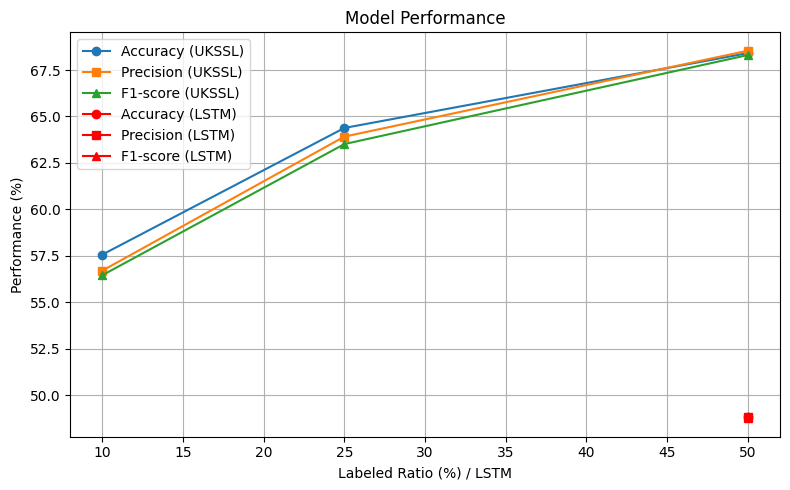

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import numpy as np
import random

# Set random seeds
def seed_everything(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
seed_everything()

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Dataset
BCCD = "/content/drive/MyDrive/BCCD_Dataset-master/content/drive/MyDrive/BCCD_Dataset-master"
test_loader = DataLoader(BCCD, batch_size=128, shuffle=False)


# Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.fc(self.conv(x))

# LSTM-based model
class LSTMModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.lstm = nn.LSTM(3*32*32, 128, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = x.unsqueeze(1)
        lstm_out, (h_n, c_n) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

# Train function (now with epochs)
def train(model, loader, optimizer, criterion, device, epochs=25):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

# Evaluate function
def evaluate(model, loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.numpy())
    return preds, targets

# UKSSL pipeline
def ukssl_pipeline(labeled_ratio):
    total = len(full_train)
    indices = list(range(total))
    random.shuffle(indices)
    labeled_len = int(total * labeled_ratio)
    labeled_idx, unlabeled_idx = indices[:labeled_len], indices[labeled_len:]

    labeled_loader = DataLoader(Subset(full_train, labeled_idx), batch_size=64, shuffle=True)
    unlabeled_loader = DataLoader(Subset(full_train, unlabeled_idx), batch_size=64, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Phase 1: Train on labeled data (25 epochs)
    train(model, labeled_loader, optimizer, criterion, device, epochs=25)

    # Phase 2: Pseudo-labeling
    pseudo_inputs, pseudo_targets = [], []
    model.eval()
    with torch.no_grad():
        for inputs, _ in unlabeled_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            max_probs, preds = probs.max(dim=1)
            mask = max_probs > 0.9
            if mask.sum() > 0:
                pseudo_inputs.append(inputs[mask].cpu())
                pseudo_targets.append(preds[mask].cpu())

    if pseudo_inputs:
        pseudo_inputs = torch.cat(pseudo_inputs)
        pseudo_targets = torch.cat(pseudo_targets)
        pseudo_dataset = TensorDataset(pseudo_inputs, pseudo_targets)
        pseudo_loader = DataLoader(pseudo_dataset, batch_size=64, shuffle=True)
        train(model, pseudo_loader, optimizer, criterion, device, epochs=25)

    # Evaluate
    preds, targets = evaluate(model, test_loader, device)
    return {
        "accuracy": accuracy_score(targets, preds),
        "precision": precision_score(targets, preds, average='macro'),
        "recall": recall_score(targets, preds, average='macro'),
        "f1": f1_score(targets, preds, average='macro')
    }

# Baselines on 100% labeled data
def baseline_models():
    full_loader = DataLoader(full_train, batch_size=1024, shuffle=False)
    X, y = next(iter(full_loader))
    X = X.view(X.size(0), -1).numpy()
    y = y.numpy()

    X_test, y_test = next(iter(DataLoader(test_set, batch_size=1024)))
    X_test = X_test.view(X_test.size(0), -1).numpy()
    y_test = y_test.numpy()

    rf = RandomForestClassifier(n_estimators=10)
    rf.fit(X, y)
    rf_preds = rf.predict(X_test)

    return {
        "Random Forest": {
            "accuracy": accuracy_score(y_test, rf_preds),
            "precision": precision_score(y_test, rf_preds, average='macro'),
            "recall": recall_score(y_test, rf_preds, average='macro'),
            "f1": f1_score(y_test, rf_preds, average='macro')
        }
    }

# Run all
ratios = [0.1, 0.25, 0.5]
ukssl_results = {}
lstm_results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for ratio in ratios:
    print(f"Running UKSSL for {int(ratio*100)}% labeled data")
    ukssl_results[f"UKSSL-{int(ratio*100)}%"] = ukssl_pipeline(ratio)

# LSTM Baseline (trained on 100% labeled data)
lstm_model = LSTMModel().to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(full_train, batch_size=64, shuffle=True)
train(lstm_model, train_loader, optimizer, criterion, device, epochs=25)
lstm_preds, lstm_targets = evaluate(lstm_model, DataLoader(test_set, batch_size=64), device)
lstm_results["LSTM"] = {
    "accuracy": accuracy_score(lstm_targets, lstm_preds),
    "precision": precision_score(lstm_targets, lstm_preds, average='macro'),
    "recall": recall_score(lstm_targets, lstm_preds, average='macro'),
    "f1": f1_score(lstm_targets, lstm_preds, average='macro')
}

baselines = baseline_models()

# Display table
table = PrettyTable()
table.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1-score"]

for label, metrics in ukssl_results.items():
    table.add_row([label, f"{metrics['accuracy']*100:.2f}%", f"{metrics['precision']*100:.2f}%", f"{metrics['recall']*100:.2f}%", f"{metrics['f1']*100:.2f}%"])

for label, metrics in lstm_results.items():
    table.add_row([label, f"{metrics['accuracy']*100:.2f}%", f"{metrics['precision']*100:.2f}%", f"{metrics['recall']*100:.2f}%", f"{metrics['f1']*100:.2f}%"])

for label, metrics in baselines.items():
    table.add_row([label, f"{metrics['accuracy']*100:.2f}%", f"{metrics['precision']*100:.2f}%", f"{metrics['recall']*100:.2f}%", f"{metrics['f1']*100:.2f}%"])

print("comparison with state-of-the-art methods:")
print(table)

# Plotting
labels = list(ukssl_results.keys()) + ["LSTM"]
acc = [ukssl_results[k]['accuracy']*100 for k in labels if "UKSSL" in k] + [lstm_results["LSTM"]['accuracy']*100]
prec = [ukssl_results[k]['precision']*100 for k in labels if "UKSSL" in k] + [lstm_results["LSTM"]['precision']*100]
f1 = [ukssl_results[k]['f1']*100 for k in labels if "UKSSL" in k] + [lstm_results["LSTM"]['f1']*100]

x = [10, 25, 50] + ["LSTM"]
plt.figure(figsize=(8, 5))
plt.plot(x[:3], acc[:3], label='Accuracy (UKSSL)', marker='o')
plt.plot(x[:3], prec[:3], label='Precision (UKSSL)', marker='s')
plt.plot(x[:3], f1[:3], label='F1-score (UKSSL)', marker='^')
plt.plot([50], [acc[3]], label='Accuracy (LSTM)', marker='o', color='red')
plt.plot([50], [prec[3]], label='Precision (LSTM)', marker='s', color='red')
plt.plot([50], [f1[3]], label='F1-score (LSTM)', marker='^', color='red')
plt.xlabel("Labeled Ratio (%) / LSTM")
plt.ylabel("Performance (%)")
plt.title("Model Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
